Based off of:
- https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb
- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers


# Imports 

In [3]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

# from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

# Problem Specifics
Using the hyperparameters, $\alpha = [1,1,1]$. Changing the hyperparameters is like changing our confidence in our initial beliefs.


In [1]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

NameError: name 'np' is not defined

# Expected Value

In [5]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


In [6]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


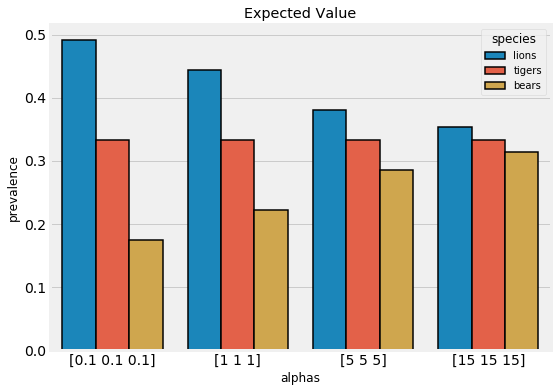

In [7]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

# PYMC3

In [10]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)

In [11]:
model

# Sampling from the Model

In [13]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2594.61draws/s]


# Inspecting Results

In [14]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.444301,0.151134,0.003662,0.158775,0.727221,1856.793538,0.999630
tigers,0.334533,0.148148,0.003772,0.072252,0.626166,1457.023254,1.001466
bears,0.221167,0.127144,0.002619,0.024441,0.476048,1687.695759,1.000950


In [24]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.420559,0.142467,0.436974
1,0.428509,0.266753,0.304737
2,0.554038,0.137729,0.308232
3,0.652903,0.101663,0.245433
4,0.412660,0.488384,0.098956


In [27]:
trace_df.shape

(2000, 3)

In [28]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(animals, pvals)))

Species: lions    Prevalence: 44.43%.
Species: tigers   Prevalence: 33.45%.
Species: bears    Prevalence: 22.12%.


In [29]:
summary.iloc[:, 3:5]

,hpd_2.5,hpd_97.5
lions,0.158775,0.727221
tigers,0.072252,0.626166
bears,0.024441,0.476048


# Posterior Plots

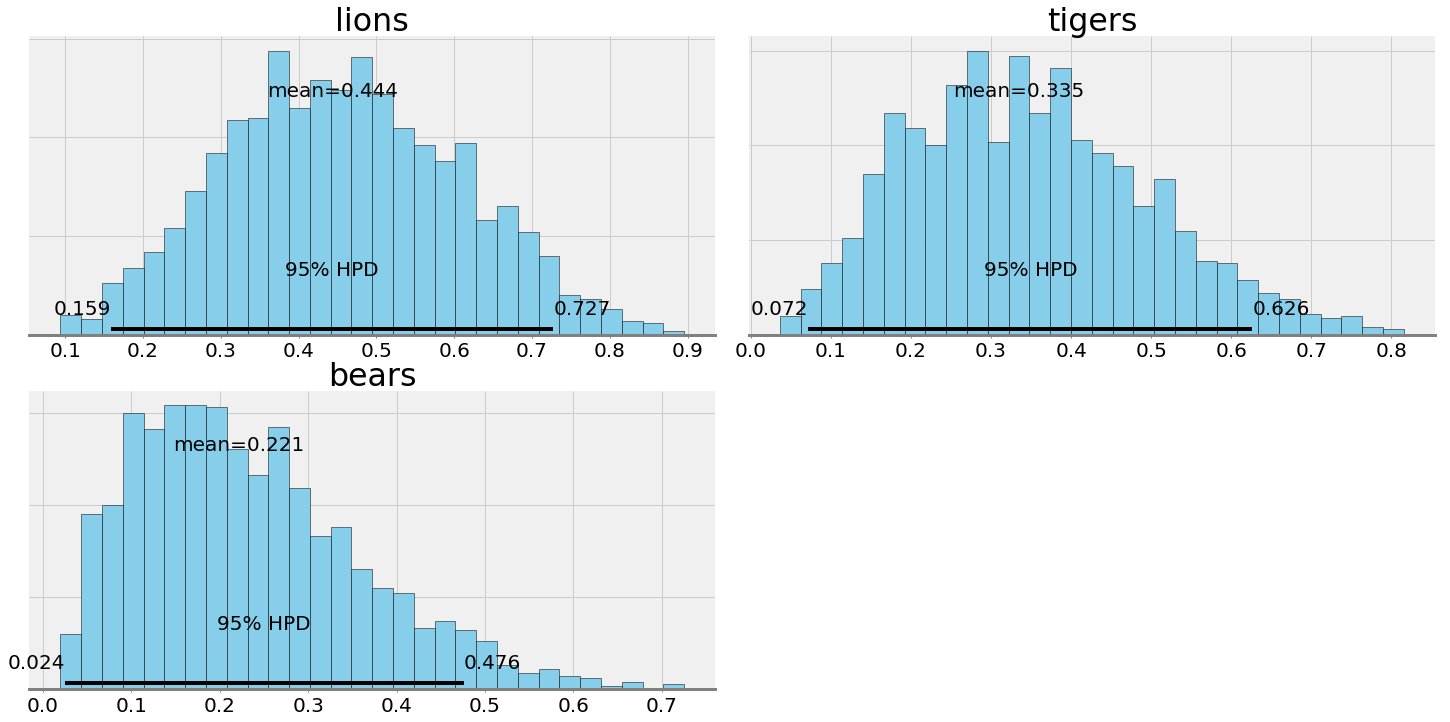

In [15]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

# Traceplot

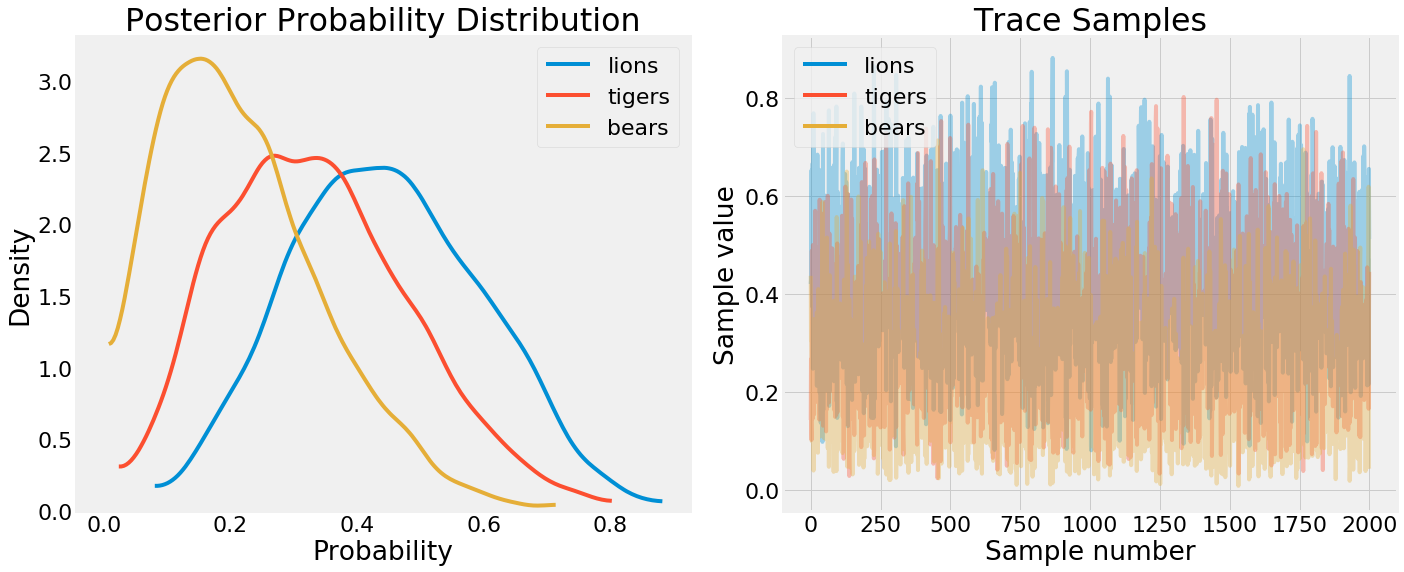

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
add_legend(ax[0][0])
add_legend(ax[0][1])

# Maximum A Posteriori Result with PyMC3

Directly finding the MAP

In [17]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))

logp = -1.8042, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 383.03it/s]

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


# Sampling from the Posterior

In [19]:
with model:
    samples = pm.sample_ppc(trace, samples = 1000)
    
dict(zip(animals, samples['observed_data'].mean(axis = 0)))

100%|██████████| 1000/1000 [00:00<00:00, 1020.37it/s]


{'lions': 2.645, 'tigers': 1.975, 'bears': 1.38}

## Estimate Number of the Animals we will see at the reserve

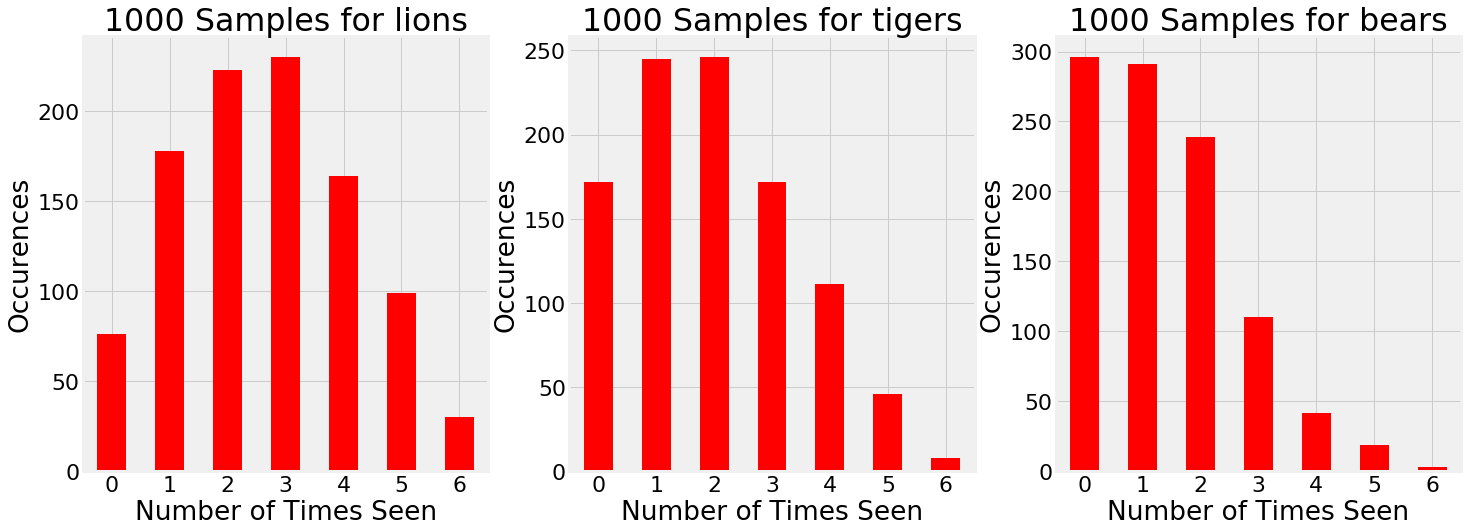

In [20]:
sample_df = pd.DataFrame(samples['observed_data'], columns = animals)

plt.figure(figsize = (22, 8))
for i, animal in enumerate(sample_df):
    plt.subplot(1, 3, i+1)
    sample_df[animal].value_counts().sort_index().plot.bar(color = 'r');
    plt.xticks(range(7), range(7), rotation = 0);
    plt.xlabel('Number of Times Seen'); plt.ylabel('Occurences');
    plt.title(f'1000 Samples for {animal}');

# Dirichlet Distribution Plotting

All Equal

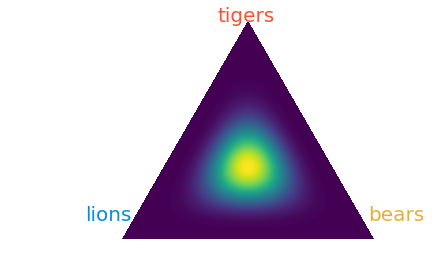

In [21]:
draw_pdf_contours(Dirichlet(6 * alphas))
annotate_plot()

After sampling

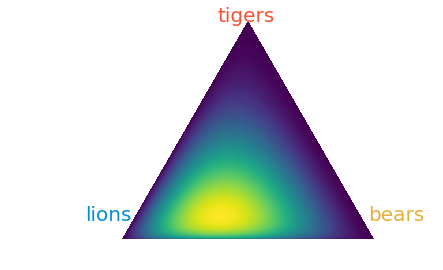

In [30]:
draw_pdf_contours(Dirichlet(6 * pvals))
annotate_plot();

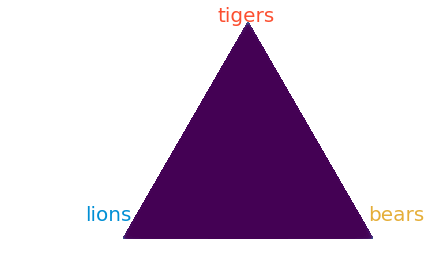

In [31]:
draw_pdf_contours(Dirichlet([0.1, 0.1, 0.1]))
annotate_plot();

# Next Observation

Sample the next observation 1000 times to see what should we get next, probability of seeing each species is proportional to that obtained from the sampling

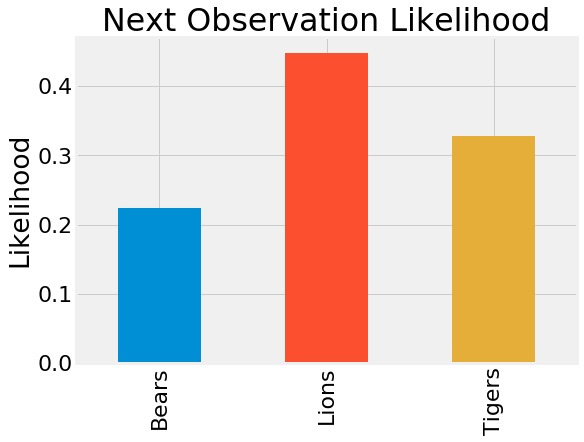

In [32]:
# Draw from the multinomial
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [33]:
next_obs.iloc[:, [0, 2]]

,variable,total
1,Bears,0.2237
3,Lions,0.4484
5,Tigers,0.3279
